In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from acessar_dados_curated import carregar_parquets_em_variaveis

In [2]:
carregar_parquets_em_variaveis(destino=globals(), nomes=["clientes_desde", "codigos_paises","contratacoes_ultimos_12_meses", "dados_clientes","historico",
                                                          "mrr","nps_relacional", "nps_transacional_aquisicao","nps_transacional_implantacao", 
                                                          "nps_transacional_onboarding","nps_transacional_produto", "nps_transacional_suporte",
                                                          "tickets", "telemetria_consolidado"])

clientes_desde ← silver/tb_clientes_desde/clientes_desde.parquet  | 10615 linhas
codigos_paises ← silver/codigos_paises/codigos_paises.parquet  | 249 linhas
contratacoes_ultimos_12_meses ← silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet  | 4314 linhas
dados_clientes ← silver/tb_dados_clientes/dados_clientes.parquet  | 238597 linhas
historico ← silver/tb_historico/historico.parquet  | 22740 linhas
mrr ← silver/tb_mrr/mrr.parquet  | 7309 linhas
nps_relacional ← silver/tb_nps_relacional/nps_relacional.parquet  | 13942 linhas
nps_transacional_aquisicao ← silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet  | 175 linhas
nps_transacional_implantacao ← silver/tb_nps_implantacao/nps_transacional_implantacao.parquet  | 662 linhas
nps_transacional_onboarding ← silver/tb_nps_onboarding/nps_transacional_onboarding.parquet  | 208 linhas
nps_transacional_produto ← silver/tb_nps_produto/nps_transacional_produto.parquet  | 113201 linhas
nps_transacional_suporte ← silver/tb_nps_

{'clientes_desde': 's3://arcana-fiap/silver/tb_clientes_desde/clientes_desde.parquet',
 'codigos_paises': 's3://arcana-fiap/silver/codigos_paises/codigos_paises.parquet',
 'contratacoes_ultimos_12_meses': 's3://arcana-fiap/silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet',
 'dados_clientes': 's3://arcana-fiap/silver/tb_dados_clientes/dados_clientes.parquet',
 'historico': 's3://arcana-fiap/silver/tb_historico/historico.parquet',
 'mrr': 's3://arcana-fiap/silver/tb_mrr/mrr.parquet',
 'nps_relacional': 's3://arcana-fiap/silver/tb_nps_relacional/nps_relacional.parquet',
 'nps_transacional_aquisicao': 's3://arcana-fiap/silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet',
 'nps_transacional_implantacao': 's3://arcana-fiap/silver/tb_nps_implantacao/nps_transacional_implantacao.parquet',
 'nps_transacional_onboarding': 's3://arcana-fiap/silver/tb_nps_onboarding/nps_transacional_onboarding.parquet',
 'nps_transacional_produto': 's3://arcana-fiap/silver/tb_nps_produto/np

In [3]:
df_clientes_desde = clientes_desde
df_codigos_paises = codigos_paises
df_contratacoes_ultimos_12_meses = contratacoes_ultimos_12_meses
df_dados_clientes = dados_clientes
df_historico = historico
df_mrr = mrr
df_nps_relacional = nps_relacional
df_nps_transacional_aquisicao = nps_transacional_aquisicao
df_nps_transacional_implantacao = nps_transacional_implantacao
df_nps_transacional_onboarding = nps_transacional_onboarding
df_nps_transacional_produto = nps_transacional_produto
df_nps_transacional_suporte = nps_transacional_suporte
df_telemetria_consolidado = telemetria_consolidado
df_tickets = tickets

In [4]:
# Janela de observação (ajuste conforme sua necessidade)
HOJE = pd.to_datetime("today")

# Base mestre: clientes únicos
base = df_clientes_desde.copy()


base["TEMPO_CONTRATO_DIAS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days)
base["TEMPO_CONTRATO_MESES"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 30)
base["TEMPO_CONTRATO_ANOS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 365)

base.head()

,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS
0,TFDICB,2023-01-27,940,31,2
1,TFCU91,2021-01-26,1671,55,4
2,TFDDYV,2022-07-18,1133,37,3
3,TEZBRW,2022-10-28,1031,34,2
4,TEZCXN,2013-05-24,4475,149,12


Funções de agregação por tabela

In [5]:
# DADOS_CLIENTES

def agg_dados_clientes(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_produtos=("DS_PROD", "nunique"),
        vl_total_contrato=("VL_TOTAL_CONTRATO", "sum"),
        segmento=("DS_SEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        subsegmento=("DS_SUBSEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        porte=("FAT_FAIXA", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        modal_comercio=("MODAL_COMERC", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
    ).reset_index()
    return out

def agg_contratacoes_12m(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_contratos_12m=("QT_CONTRATACOES_12M", "sum"),
        vl_contratos_12m=("VL_CONTRATACOES_12M", "sum")
    ).reset_index()
    out["contratou_ult_12m"] = (out["n_contratos_12m"] > 0).astype(int)
    return out


def agg_nps_geral(df, prefixo):
    # Colunas numéricas de nota
    num_cols = [c for c in df.columns if c.startswith("NOTA")]
    grp = df.groupby("COD_CLIENTE")
    out = grp[num_cols].mean().add_prefix(f"{prefixo}_").reset_index()
    out[f"{prefixo}_respondeu"] = grp.size().reset_index(name="n")["n"].astype(int)
    out[f"{prefixo}_respondeu"] = (out[f"{prefixo}_respondeu"]>0).astype(int)
    return out


def agg_telemetria(df):
    out = df.groupby("COD_CLIENTE").agg(
        tele_eventos=("DURACAO_EVENTO","sum"),
        tele_modulos=("ID_MODULO","nunique"),
        tele_linhas_produto=("ID_LINHA_PRODUTO","nunique"),
    ).reset_index()
    return out


def agg_tickets(df):
    # indicador de crítico
    if "PRIORIDADE_TICKET" in df.columns:
        df["is_critico"] = df["PRIORIDADE_TICKET"].astype(str).str.lower().isin(["low","normal","high","urgent"]).astype(int)
    else:
        df["is_critico"] = 0

    out = df.groupby("COD_CLIENTE").agg(
        n_tickets=("BK_TICKET","count"),
        pct_tickets_criticos=("is_critico","mean")
    ).reset_index()
    return out


def agg_historico(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_propostas=("NR_PROPOSTA","nunique"),
        vl_total_propostas=("VL_TOTAL","sum"),
        prc_unitario_medio=("PRC_UNITARIO","mean")
    ).reset_index()
    return out

In [6]:
def left_merge(a, b, on="COD_CLIENTE"):
    return a.merge(b, on=on, how="left")

# 4.1 agregações
agg_dc   = agg_dados_clientes(df_dados_clientes)
agg_ct12 = agg_contratacoes_12m(df_contratacoes_ultimos_12_meses)
agg_mrr_ = df_mrr

agg_nps_rel = agg_nps_geral(df_nps_relacional, "nps_rel")
agg_nps_aq  = agg_nps_geral(df_nps_transacional_aquisicao, "nps_aquis")
agg_nps_impl= agg_nps_geral(df_nps_transacional_implantacao, "nps_impl")
agg_nps_onb = agg_nps_geral(df_nps_transacional_onboarding, "nps_onb")
agg_nps_sup = agg_nps_geral(df_nps_transacional_suporte, "nps_sup")

agg_tel  = agg_telemetria(df_telemetria_consolidado)
agg_tic  = agg_tickets(df_tickets)
agg_hist = agg_historico(df_historico)

# 4.2 master join
df = base.copy()
for part in [agg_dc, agg_ct12, agg_mrr_, agg_nps_rel, agg_nps_aq, agg_nps_impl, agg_nps_onb, agg_nps_sup, agg_tel, agg_tic, agg_hist]:
    df = left_merge(df, part)

# 4.3 faltantes → 0 para contagens/somas; deixam NaN para médias de NPS/valores
count_cols = [
    "n_produtos","n_contratos_12m","contratou_ult_12m","tele_eventos","tele_modulos","tele_linhas_produto",
    "n_tickets","n_propostas"
]
for c in count_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# 4.4 flags respondeu NPS (se não tiver, vira 0)
for c in [col for col in df.columns if c.endswith("_respondeu")]:
    df[c] = df[c].fillna(0).astype(int)

print(df.shape)
df.head()

(10615, 62)


,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,subsegmento,porte,...,nps_sup_NOTA_SATISFACAO,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
0,TFDICB,2023-01-27,940,31,2,7,12899.477479,VAREJO,CONCESSIONARIA DE VEICULOS,Faixa 03 - De 15 M ate 25 M,...,NaN,NaN,0.0,0.0,0.0,369.0,1.0,0.0,NaN,NaN
1,TFCU91,2021-01-26,1671,55,4,5,8271.379438,LOGISTICA,TRANSPORTADOR,"Faixa 00 - Ate 4,5 M",...,NaN,NaN,0.0,0.0,0.0,68.0,1.0,0.0,NaN,NaN
2,TFDDYV,2022-07-18,1133,37,3,7,94240.254204,MANUFATURA,METAL-MECANICO & PLASTICO,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
3,TEZBRW,2022-10-28,1031,34,2,1,0.008408,SERVICOS,PROVEDOR DE SERVICOS,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
4,TEZCXN,2013-05-24,4475,149,12,45,103720.024034,MANUFATURA,METAL-MECANICO & PLASTICO,Faixa 07 - De 75 M ate 150 M,...,9.896,1.0,0.0,0.0,0.0,709.0,1.0,7.0,44989.370466,1482.566496


In [7]:
# Categóricas principais (ajuste conforme disponibilidade)
cat_cols = [c for c in ["segmento","subsegmento","porte","modal_comercio"] if c in df.columns]

# Numéricas candidatas
num_cols = [
    "tempo_de_casa_anos",
    "n_produtos","vl_total_contrato",
    "n_contratos_12m","vl_contratos_12m","contratou_ult_12m",
    "MRR_12M",
    # NPS médios (podem ter NaN)
    *[c for c in df.columns if c.startswith(("nps_rel_","nps_aquis_","nps_impl_","nps_onb_","nps_sup_")) and not c.endswith("_respondeu")],
    # Flags respondeu
    *[c for c in df.columns if c.endswith("_respondeu")],
    # Telemetria
    "tele_eventos","tele_modulos","tele_linhas_produto",
    # Tickets / CRM
    "n_tickets","pct_tickets_criticos",
    "n_propostas","vl_total_propostas","prc_unitario_medio"
]
num_cols = [c for c in num_cols if c in df.columns]

X = df[["COD_CLIENTE"] + cat_cols + num_cols].copy()

# Pipelines
num_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01))
])

prep = ColumnTransformer(transformers=[
    ("num", num_prep, num_cols),
    ("cat", cat_prep, cat_cols)
])


In [8]:
def fit_kmeans_for_k(Xdf, k, prep):
    pipe = Pipeline(steps=[
        ("prep", prep),
        ("model", KMeans(n_clusters=k, n_init=20, random_state=42))
    ])
    labels = pipe.fit_predict(Xdf[cat_cols + num_cols])
    # silhouette no espaço transformado
    X_emb = pipe.named_steps["prep"].transform(Xdf[cat_cols + num_cols])
    sil = silhouette_score(X_emb, labels)
    return pipe, labels, sil

melhor = {"sil": -1, "k": None, "pipe": None, "labels": None}
ks = range(2, 11)

for k in ks:
    pipe, labels, sil = fit_kmeans_for_k(X, k, prep)
    print(f"K={k} | silhouette={sil:.3f}")
    if sil > melhor["sil"]:
        melhor = {"sil": sil, "k": k, "pipe": pipe, "labels": labels}

print(f"\n✅ Melhor K={melhor['k']} | silhouette={melhor['sil']:.3f}")
df["cluster"] = melhor["labels"]
model = melhor["pipe"]


K=2 | silhouette=0.863
K=3 | silhouette=0.874
K=4 | silhouette=0.561
K=5 | silhouette=0.565
K=6 | silhouette=0.420
K=7 | silhouette=0.416
K=8 | silhouette=0.160
K=9 | silhouette=0.160
K=10 | silhouette=0.142

✅ Melhor K=3 | silhouette=0.874


In [9]:
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_produtos',
                                                   'vl_total_contrato',
                                                   'n_contratos_12m',
                                                   'vl_contratos_12m',
                                                   'contratou_ult_12m',
                                                   'MRR_12M',
                                                   'nps_rel_NOTA_NPS',
                                                   'nps_rel_NOTA_RESPOSTA_UNIDADE',
                                                   'nps_rel_NOTA_SUPTEC_AGILIDADE',
                                                   'nps_rel_NOT...
                                                   'nps_impl_NOTA_PRAZOS',
                                                   'nps_onb_NOTA_RECOMENDACAO',
                                                   'nps_onb_NOTA_ATENDIMENTO_CS_ONBOARDING', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.01))]),
                                                  ['segmento', 'subsegmento',
                                                   'porte',
                                                   'modal_comercio'])])),
                ('model', KMeans(n_clusters=3, n_init=20, random_state=42))])

In [10]:
# Estatísticas por cluster
perfil_num = df.groupby("cluster")[num_cols].mean().round(2)
perfil_cat = {}
for c in cat_cols:
    topcats = (df.groupby("cluster")[c]
                 .agg(lambda s: s.value_counts(normalize=True).head(3).to_dict()))
    perfil_cat[c] = topcats

display(perfil_num)
print("\nTop categorias por cluster:")
for c, d in perfil_cat.items():
    print(f"\n{c}:")
    for cl, top in d.items():
        print(f"  cluster {cl}: {top}")


,n_produtos,vl_total_contrato,n_contratos_12m,vl_contratos_12m,contratou_ult_12m,MRR_12M,nps_rel_NOTA_NPS,nps_rel_NOTA_RESPOSTA_UNIDADE,nps_rel_NOTA_SUPTEC_AGILIDADE,nps_rel_NOTA_SUPTEC_ATENDIMENTO,...,nps_onb_respondeu,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
cluster,,,,,,,,,,,,,,,,,,,,,
0,32.59,398540.64,2.04,216081.95,0.85,3167.24,7.26,6.93,6.23,6.80,...,NaN,1.0,0.0,0.0,0.0,344.63,1.0,3.63,277756.90,151738.88
1,14.07,69299.59,0.75,10384.59,0.41,668.15,8.17,8.24,7.51,8.09,...,1.0,1.0,0.0,0.0,0.0,91.32,1.0,0.93,21498.10,1413.46
2,20.50,41122.95,1.50,41122.95,1.00,885.48,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,47.00,1.0,4.00,55881.23,816.58



Top categorias por cluster:

segmento:
  cluster 0: {'VAREJO': 0.3333333333333333, 'MANUFATURA': 0.2222222222222222, 'SERVICOS': 0.14814814814814814}
  cluster 1: {'SERVICOS': 0.2285093519743057, 'VAREJO': 0.20555450595125638, 'MANUFATURA': 0.1951634233893822}
  cluster 2: {'EDUCACIONAL': 0.5, 'SERVICOS': 0.5}

subsegmento:
  cluster 0: {'SUPERIOR': 0.07407407407407407, 'VAREJO': 0.07407407407407407, 'CONCESSIONARIA DE VEICULOS': 0.07407407407407407}
  cluster 1: {'ATACADISTA E DISTRIBUIDOR': 0.11667453944260746, 'PROVEDOR SERVICOS': 0.11639111950873877, 'HOSPEDAGEM': 0.053094000944733113}
  cluster 2: {'EDUCACAO CONTINUADA': 0.5, 'PROVEDOR SERVICOS': 0.5}

porte:
  cluster 0: {'Sem Informações de Faturamento': 0.25925925925925924, 'Faixa 07 - De 75 M ate 150 M': 0.1111111111111111, 'Faixa 05 - De 35 M ate 50 M': 0.1111111111111111}
  cluster 1: {'Sem Informações de Faturamento': 0.4771396183638768, 'Faixa 00 - Ate 4,5 M': 0.1533156999811071, 'Faixa 02 - De 7,5 M ate 15 M': 0.06905346

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_text

X_tr = model.named_steps["prep"].transform(X[cat_cols + num_cols])
y_tr = df["cluster"].values

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_tr, y_tr)

print(export_text(dt, feature_names=model.named_steps["prep"].get_feature_names_out().tolist()))


|--- num__nps_impl_NOTA_COMUNICACAO <= -7.17
|   |--- class: 0
|--- num__nps_impl_NOTA_COMUNICACAO >  -7.17
|   |--- num__nps_onb_NOTA_DURACAO_REUNIAO_ONBOARDING <= -44.80
|   |   |--- class: 2
|   |--- num__nps_onb_NOTA_DURACAO_REUNIAO_ONBOARDING >  -44.80
|   |   |--- num__vl_contratos_12m <= 55.74
|   |   |   |--- class: 1
|   |   |--- num__vl_contratos_12m >  55.74
|   |   |   |--- class: 0



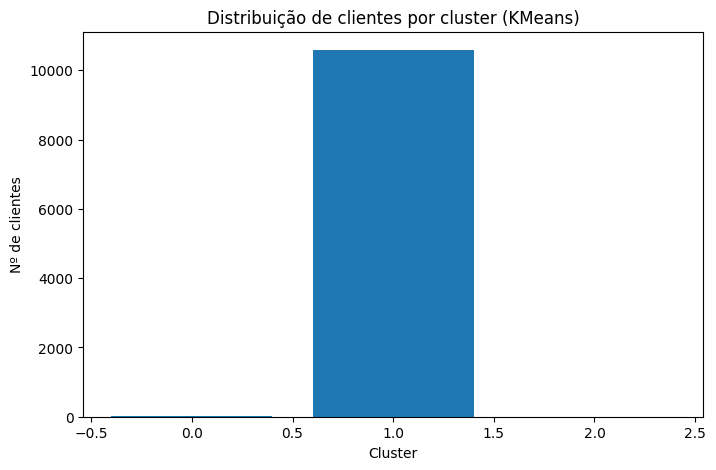

In [12]:
import matplotlib.pyplot as plt

cluster_counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Cluster")
plt.ylabel("Nº de clientes")
plt.title("Distribuição de clientes por cluster (KMeans)")
plt.show()


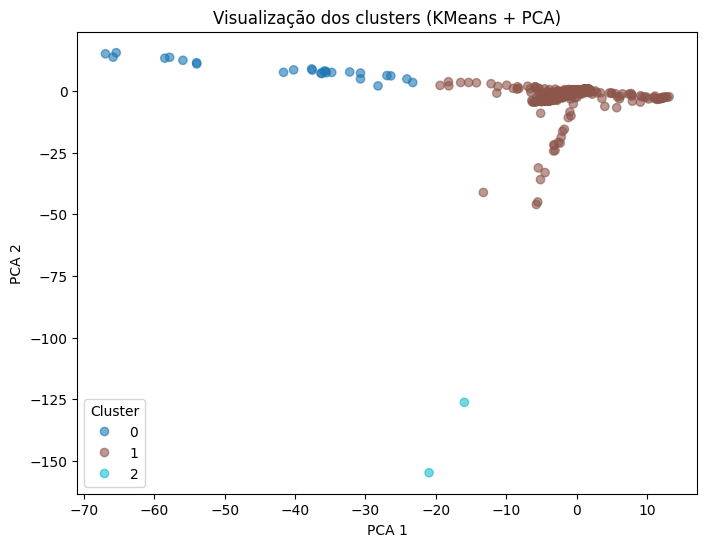

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# seleciona apenas features usadas no KMeans
X_features = df[num_cols + cat_cols]  # ajuste conforme seu pré-processamento
X_proc = model.named_steps["prep"].transform(X_features)  # pipeline usado no treino

# reduz para 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_proc)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="tab10", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualização dos clusters (KMeans + PCA)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

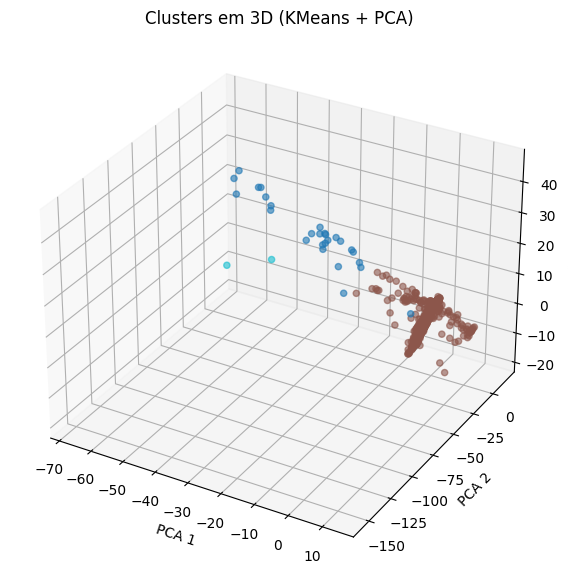

In [14]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_proc)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=df["cluster"], cmap="tab10", alpha=0.6)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("Clusters em 3D (KMeans + PCA)")
plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Distribuição dos clusters
def plot_cluster_distribution(df, cluster_col="cluster"):
    cluster_counts = df[cluster_col].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.xlabel("Cluster")
    plt.ylabel("Nº de clientes")
    plt.title("Distribuição de clientes por cluster")
    plt.show()
    return cluster_counts

# 2) Percentual de missing e zeros
def feature_quality_report(df, num_cols):
    report = pd.DataFrame({
        "missing_%": df[num_cols].isna().mean()*100,
        "zeros_%": (df[num_cols]==0).mean()*100
    })
    return report.sort_values("missing_%", ascending=False)

# 3) Estatísticas por cluster
def cluster_summary(df, cluster_col, num_cols):
    return df.groupby(cluster_col)[num_cols].mean().round(2)

# 4) Heatmap de z-scores médios por cluster
def cluster_heatmap(df, cluster_col, num_cols):
    cluster_means = df.groupby(cluster_col)[num_cols].mean()
    zscores = (cluster_means - df[num_cols].mean())/df[num_cols].std()
    
    plt.figure(figsize=(12,6))
    sns.heatmap(zscores.T, annot=True, fmt=".1f", cmap="coolwarm", center=0)
    plt.title("Z-scores médios por cluster")
    plt.ylabel("Features")
    plt.xlabel("Cluster")
    plt.show()
    return zscores


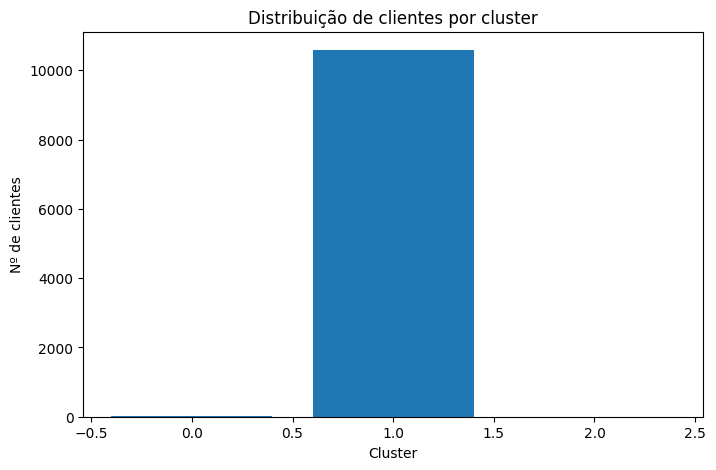

Qualidade das features:


,missing_%,zeros_%
nps_aquis_NOTA_CONHECIMENTO,99.783325,0.000000
nps_aquis_NOTA_AGILIDADE,99.783325,0.009421
nps_aquis_NOTA_FLEXIBILIDADE,99.783325,0.000000
nps_aquis_NOTA_FACILIDADE,99.783325,0.009421
nps_aquis_NOTA_CUSTO,99.783325,0.000000
nps_onb_NOTA_CLAREZA_INFORMACOES_CS,99.613754,0.000000
nps_onb_NOTA_CLAREZA_CANAIS_COMUNICACAO,99.613754,0.009421
nps_onb_NOTA_DURACAO_REUNIAO_ONBOARDING,99.613754,0.009421
nps_onb_NOTA_EXPECTATIVAS_ATENDIDAS_ONBOARDING,99.613754,0.018841
nps_aquis_NOTA_NPS,99.566651,0.009421


Resumo dos clusters:


,n_produtos,vl_total_contrato,n_contratos_12m,vl_contratos_12m,contratou_ult_12m,MRR_12M,nps_rel_NOTA_NPS,nps_rel_NOTA_RESPOSTA_UNIDADE,nps_rel_NOTA_SUPTEC_AGILIDADE,nps_rel_NOTA_SUPTEC_ATENDIMENTO,...,nps_onb_respondeu,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
cluster,,,,,,,,,,,,,,,,,,,,,
0,32.59,398540.64,2.04,216081.95,0.85,3167.24,7.26,6.93,6.23,6.80,...,NaN,1.0,0.0,0.0,0.0,344.63,1.0,3.63,277756.90,151738.88
1,14.07,69299.59,0.75,10384.59,0.41,668.15,8.17,8.24,7.51,8.09,...,1.0,1.0,0.0,0.0,0.0,91.32,1.0,0.93,21498.10,1413.46
2,20.50,41122.95,1.50,41122.95,1.00,885.48,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,47.00,1.0,4.00,55881.23,816.58


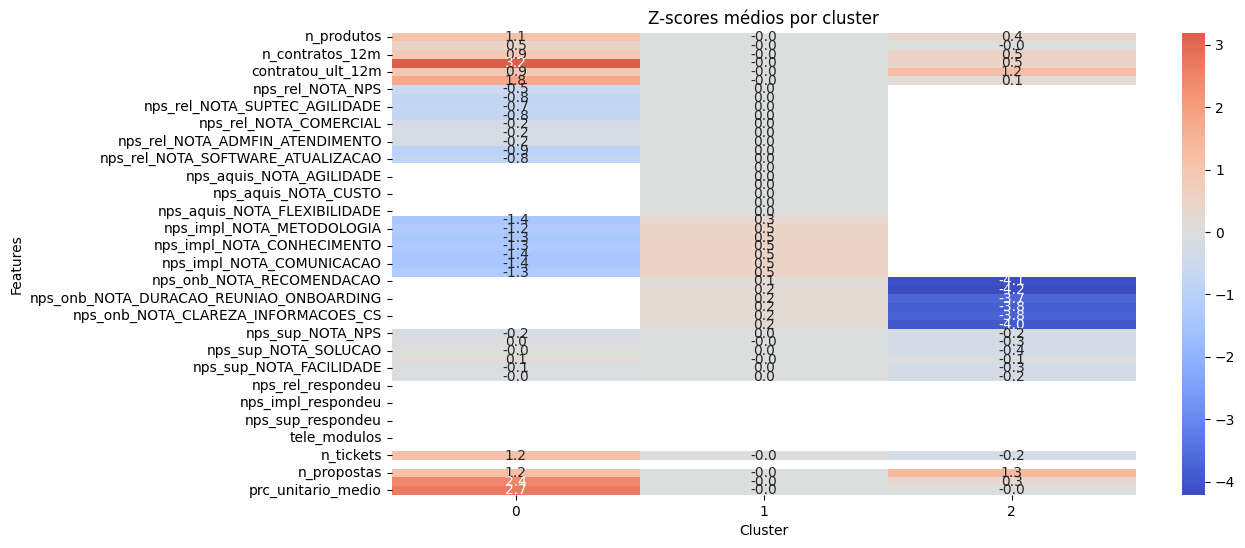

,n_produtos,vl_total_contrato,n_contratos_12m,vl_contratos_12m,contratou_ult_12m,MRR_12M,nps_rel_NOTA_NPS,nps_rel_NOTA_RESPOSTA_UNIDADE,nps_rel_NOTA_SUPTEC_AGILIDADE,nps_rel_NOTA_SUPTEC_ATENDIMENTO,...,nps_onb_respondeu,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.091195,0.452179,0.881498,3.192498,0.906880,1.780246,-0.546265,-0.767948,-0.699267,-0.767462,...,NaN,NaN,NaN,NaN,NaN,1.163661,NaN,1.184065,2.415974,2.657406
1,-0.002854,-0.001146,-0.002345,-0.017336,-0.002541,-0.006643,0.002144,0.003090,0.002694,0.003098,...,NaN,NaN,NaN,NaN,NaN,-0.002929,NaN,-0.003275,-0.014553,-0.015824
2,0.377011,-0.039942,0.511682,0.462326,1.208493,0.148749,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.207014,NaN,1.347257,0.311559,-0.026439


In [16]:
# 1. Distribuição
plot_cluster_distribution(df, "cluster")

# 2. Qualidade das features
num_cols_selected = num_cols  
quality = feature_quality_report(df, num_cols_selected)
print("Qualidade das features:")
display(quality.head(30))

# 3. Estatísticas médias
summary = cluster_summary(df, "cluster", num_cols_selected)
print("Resumo dos clusters:")
display(summary)

# 4. Heatmap de perfis
cluster_heatmap(df, "cluster", num_cols_selected)

Mantendo features: ['n_produtos', 'vl_total_contrato', 'n_contratos_12m', 'vl_contratos_12m', 'MRR_12M', 'n_tickets', 'n_propostas', 'prc_unitario_medio', 'tele_eventos', 'tele_modulos', 'tele_linhas_produto', 'nps_rel_NOTA_NPS', 'nps_rel_NOTA_RESPOSTA_UNIDADE', 'nps_rel_NOTA_SUPTEC_AGILIDADE']
K=2 | silhouette=0.358
K=3 | silhouette=0.360
K=4 | silhouette=0.294
K=5 | silhouette=0.188
K=6 | silhouette=0.283

✅ Melhor K=3 com silhouette=0.360


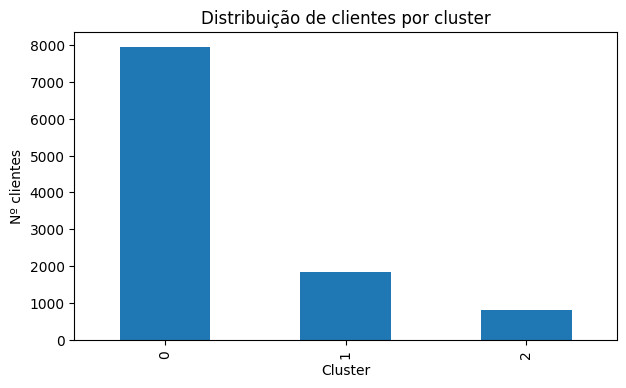

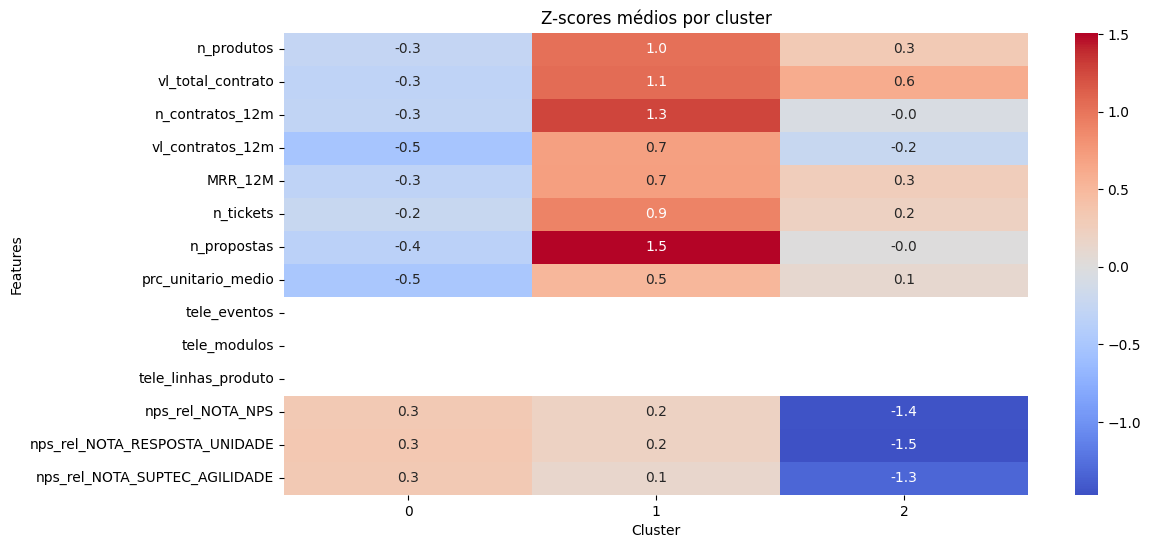

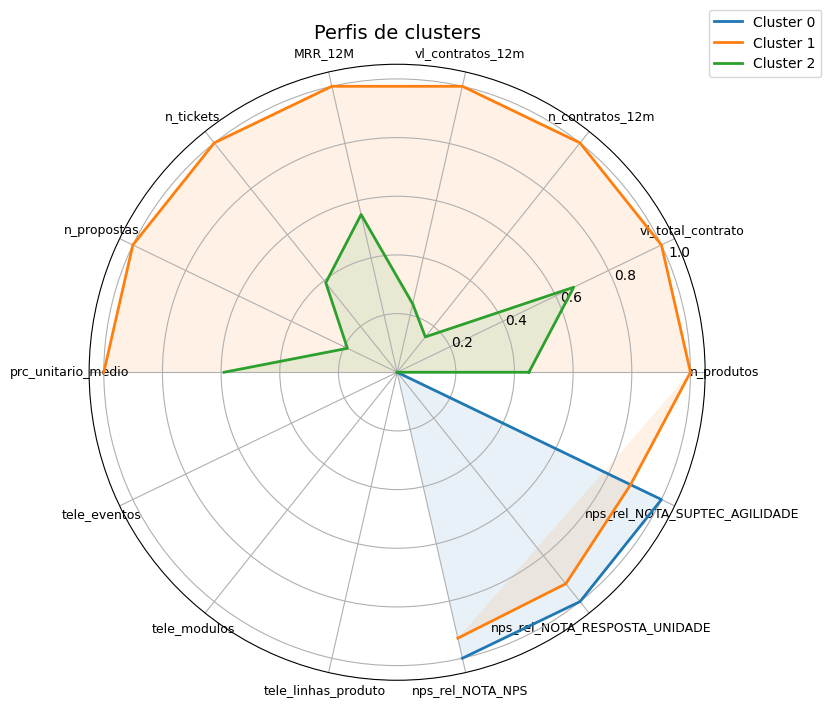

In [17]:
# ============ 1. Seleção de features ============
# lista inicial de numéricas (ajuste conforme seu df)
num_cols_selected = [
    "n_produtos","vl_total_contrato","n_contratos_12m","vl_contratos_12m","MRR_12M",
    "n_tickets","n_propostas","prc_unitario_medio",
    "tele_eventos","tele_modulos","tele_linhas_produto",
    "nps_rel_NOTA_NPS","nps_rel_NOTA_RESPOSTA_UNIDADE","nps_rel_NOTA_SUPTEC_AGILIDADE"
]

df_cluster = df.copy()

# remover features com >95% missing
missing_pct = df_cluster[num_cols_selected].isna().mean()
cols_keep = missing_pct[missing_pct < 0.95].index.tolist()
print("Mantendo features:", cols_keep)

# aplicar log1p em variáveis financeiras
log_cols = ["vl_total_contrato","vl_contratos_12m","MRR_12M","n_propostas","prc_unitario_medio"]
for c in log_cols:
    if c in df_cluster.columns:
        df_cluster[c] = np.log1p(df_cluster[c])

# ============ 2. Pré-processamento ============
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_proc = pipe.fit_transform(df_cluster[cols_keep])

# ============ 3. Escolha de K ============
melhor = {"k":None,"score":-1,"labels":None,"model":None}
for k in range(2,7):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_proc)
    score = silhouette_score(X_proc, labels)
    print(f"K={k} | silhouette={score:.3f}")
    if score > melhor["score"]:
        melhor = {"k":k,"score":score,"labels":labels,"model":km}

print(f"\n✅ Melhor K={melhor['k']} com silhouette={melhor['score']:.3f}")
df_cluster["cluster"] = melhor["labels"]

# ============ 4. Diagnóstico ============
# Distribuição
plt.figure(figsize=(7,4))
df_cluster["cluster"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição de clientes por cluster")
plt.xlabel("Cluster")
plt.ylabel("Nº clientes")
plt.show()

# Heatmap de z-scores
cluster_means = df_cluster.groupby("cluster")[cols_keep].mean()
zscores = (cluster_means - df_cluster[cols_keep].mean())/df_cluster[cols_keep].std()

plt.figure(figsize=(12,6))
sns.heatmap(zscores.T, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Z-scores médios por cluster")
plt.ylabel("Features")
plt.xlabel("Cluster")
plt.show()

# ============ 5. Radar chart ============
def plot_radar(df_means, features, title="Radar dos clusters"):
    """
    df_means: DataFrame cluster x feature (já normalizado 0-1 ou z-score)
    """
    from math import pi
    categories = features
    N = len(categories)

    # ângulos
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    for i, row in df_means.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9)
    plt.title(title, size=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()

# Normalizar médias para [0,1] p/ radar
radar_data = cluster_means.copy()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())
plot_radar(radar_norm, radar_norm.columns.tolist(), "Perfis de clusters")

In [20]:
df_kmed.head()

,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,subsegmento,porte,...,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio,cluster
0,TFDICB,2023-01-27,940,31,2,7,9.465020,VAREJO,CONCESSIONARIA DE VEICULOS,Faixa 03 - De 15 M ate 25 M,...,NaN,0.0,0.0,0.0,369.0,1.0,0.000000,NaN,NaN,2
1,TFCU91,2021-01-26,1671,55,4,5,9.020677,LOGISTICA,TRANSPORTADOR,"Faixa 00 - Ate 4,5 M",...,NaN,0.0,0.0,0.0,68.0,1.0,0.000000,NaN,NaN,5
2,TFDDYV,2022-07-18,1133,37,3,7,11.453613,MANUFATURA,METAL-MECANICO & PLASTICO,Sem Informações de Faturamento,...,NaN,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN,0
3,TEZBRW,2022-10-28,1031,34,2,1,0.008373,SERVICOS,PROVEDOR DE SERVICOS,Sem Informações de Faturamento,...,NaN,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN,4
4,TEZCXN,2013-05-24,4475,149,12,45,11.549460,MANUFATURA,METAL-MECANICO & PLASTICO,Faixa 07 - De 75 M ate 150 M,...,1.0,0.0,0.0,0.0,709.0,1.0,2.079442,44989.370466,7.302204,5


In [21]:
df_dados_clientes.head()

,COD_CLIENTE,DS_PROD,DS_LIN_REC,CIDADE_CLIENTE,DS_CNAE,DS_SEGMENTO,DS_SUBSEGMENTO,FAT_FAIXA,MARCA_TOTVS,MODAL_COMERC,PAIS_CLIENTE,PERIODICIDADE_COBRANCA,SIT_CONTRATO,UF_CLIENTE,VL_TOTAL_CONTRATO,DATA_ASSINATURA_CONTRATO
0,99958,SMS FULL TOTVS TRAD,SMS TOTVS SERIE T,JOINVILLE,PESSOA FISICA (SEM CNAE),SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,MODALIDADE TRADICIONAL,105,00 - Mensal,GRATUITO,SC,1.633817e+06,2016-04-07
1,T00053,SMS COLAB NEO 2500 DOC,SMS TOTVS SERIE T,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,MANUFATURA - PARCEIRO,MODALIDADE TRADICIONAL,105,00 - Mensal,ATIVO,RJ,3.411556e+02,2015-02-27
2,T00053,HORA SUPORTE,CONSULTORIA TRADICIONAL,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,SERVICOS DE IMPLANTACAO,MODALIDADE SERVICOS NÃO RECORRENTES,105,00 - Mensal,CANCELADO,RJ,4.533860e+01,1997-11-28
3,99958,CDU FULL TOTVS TRAD,CDU TOTVS SERIE T,JOINVILLE,PESSOA FISICA (SEM CNAE),SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,CROSS - TRADICIONAL,MODALIDADE TRADICIONAL,105,00 - Mensal,GRATUITO,SC,4.203437e+01,2016-04-07
4,T00053,PROGRESS USER 11 CDU,CDU TOTVS SERIE T,RIODEJANEIRO,Fabricacao de preparacoes farmaceuticas,MANUFATURA,BENS DURAVEIS,Faixa 05 - De 35 M ate 50 M,PROGRESS,MODALIDADE TRADICIONAL,105,00 - Mensal,TROCADO,RJ,1.177080e-01,2017-11-22


In [30]:
df_kmed

,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,subsegmento,porte,...,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio,cluster,UF_CLIENTE
2,TFDDYV,2022-07-18,1133,37,3,7,11.453613,MANUFATURA,METAL-MECANICO & PLASTICO,Sem Informações de Faturamento,...,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN,0,SP
8,TEZODM,2016-04-11,3422,114,9,4,8.717612,CONSTRUCAO E PROJETOS,CONSTRUTORAS,"Faixa 00 - Ate 4,5 M",...,0.0,0.0,0.0,5.0,1.0,0.000000,NaN,NaN,1,SP
14,T10271,2003-04-28,8154,271,22,21,11.994269,SERVICOS,PROVEDOR SERVICOS,Faixa 09 - De 300 M ate 500 M,...,0.0,0.0,0.0,19.0,1.0,0.000000,NaN,NaN,4,SP
17,TB2891,2016-12-12,3177,105,8,1,6.841724,VAREJO,SUPERMERCADO,"Faixa 02 - De 7,5 M ate 15 M",...,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN,2,SP
18,TFBJX0,2016-02-03,3490,116,9,18,10.481103,DISTRIBUICAO,ATACADISTA E DISTRIBUIDOR,Sem Informações de Faturamento,...,0.0,0.0,0.0,77.0,1.0,0.000000,NaN,NaN,3,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10609,TDCDNY,2022-07-21,1130,37,3,3,4.279043,SERVICOS,VIAGENS,Sem Informações de Faturamento,...,0.0,0.0,0.0,0.0,NaN,0.000000,NaN,NaN,4,SP
10611,TFBYAZ,2004-12-08,7564,252,20,36,9.752587,HOSPITALITY,HOSPEDAGEM,Sem Informações de Faturamento,...,0.0,0.0,0.0,67.0,1.0,0.693147,2808.4794,4.342569,0,SP
10612,T04630,1996-10-31,10524,350,28,36,10.911163,SERVICOS,PROVEDOR SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",...,0.0,0.0,0.0,7.0,1.0,0.000000,NaN,NaN,4,SP
10613,TFCIUB,2019-07-30,2217,73,6,10,11.165772,SERVICOS,OUTRAS ATIVIDADES DE SERVIÇOS FINANCEIRO,Faixa 07 - De 75 M ate 150 M,...,0.0,0.0,0.0,5.0,1.0,0.000000,NaN,NaN,4,SP


In [32]:
df = df_kmed.copy()

Mantendo numéricas: ['n_produtos', 'vl_total_contrato', 'n_contratos_12m', 'vl_contratos_12m', 'MRR_12M', 'n_tickets', 'n_propostas', 'prc_unitario_medio', 'tele_eventos', 'tele_modulos', 'tele_linhas_produto', 'nps_rel_NOTA_NPS', 'nps_rel_NOTA_RESPOSTA_UNIDADE', 'nps_rel_NOTA_SUPTEC_AGILIDADE']
Mantendo categóricas: ['segmento', 'subsegmento', 'porte', 'modal_comercio']
cluster
2    1004
5     780
3     544
6     532
1     471
4     267
0     258
Name: count, dtype: int64


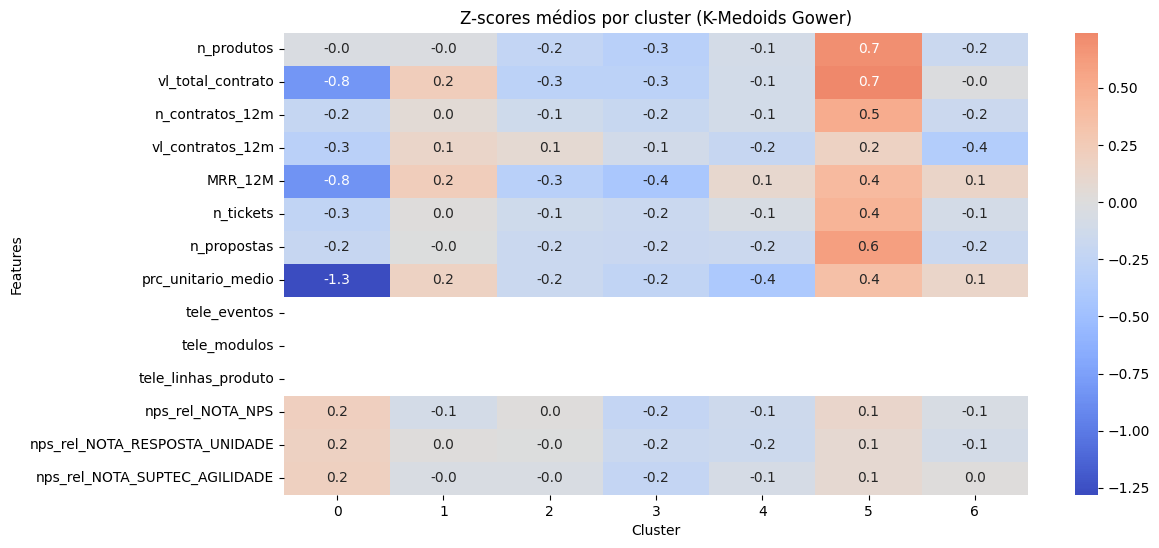

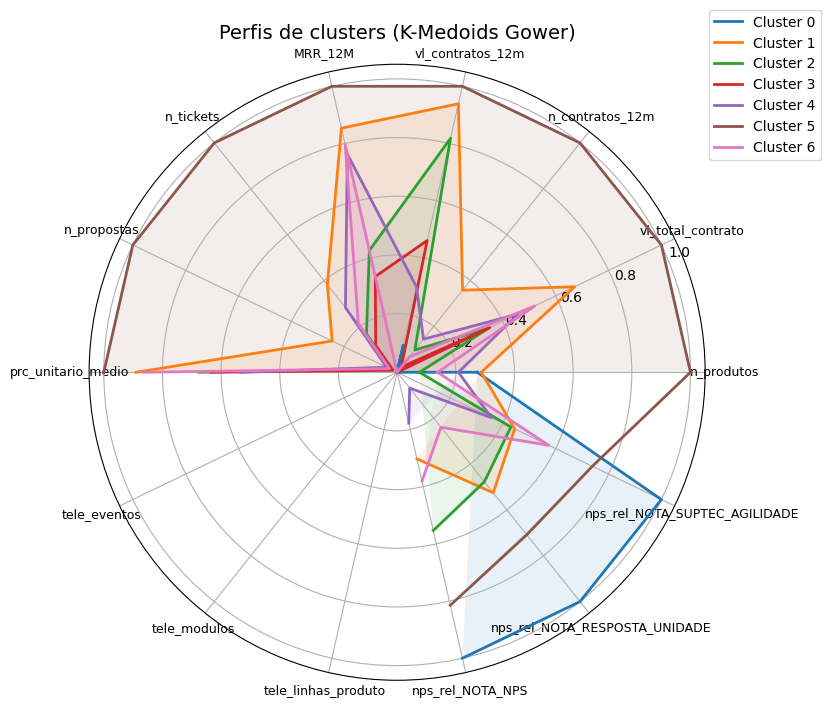

In [35]:
# !pip install scikit-learn-extra --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from math import pi

# ============ 1. Seleção e pré-processamento ============
num_cols_selected = [
    "n_produtos","vl_total_contrato","n_contratos_12m","vl_contratos_12m","MRR_12M",
    "n_tickets","n_propostas","prc_unitario_medio",
    "tele_eventos","tele_modulos","tele_linhas_produto",
    "nps_rel_NOTA_NPS","nps_rel_NOTA_RESPOSTA_UNIDADE","nps_rel_NOTA_SUPTEC_AGILIDADE"
]

cat_cols_selected = [c for c in ["segmento","subsegmento","porte","modal_comercio"] if c in df.columns]

df_kmed = df.copy()

# Remover features com >95% missing
missing_pct = df_kmed[num_cols_selected].isna().mean()
num_cols = missing_pct[missing_pct < 0.95].index.tolist()
print("Mantendo numéricas:", num_cols)
print("Mantendo categóricas:", cat_cols_selected)

# Log transform nas financeiras
log_cols = ["vl_total_contrato","vl_contratos_12m","MRR_12M","n_propostas","prc_unitario_medio"]
for c in log_cols:
    if c in df_kmed.columns:
        df_kmed[c] = np.log1p(df_kmed[c])

# ============ 2. Distância de Gower ============
def _prepare_gower(Z, num_cols, cat_cols):
    Z_num = Z[num_cols].copy() if num_cols else pd.DataFrame(index=Z.index)
    Z_cat = Z[cat_cols].copy().astype(str) if cat_cols else pd.DataFrame(index=Z.index)

    num_min = Z_num.min(numeric_only=True)
    num_max = Z_num.max(numeric_only=True)
    num_rng = (num_max - num_min).replace(0, 1.0)

    return Z_num, Z_cat, num_min, num_rng

def gower_pairwise(A, B, num_cols, cat_cols, num_min, num_rng):
    A_num = A[num_cols].values.astype(float) if num_cols else np.empty((len(A), 0))
    B_num = B[num_cols].values.astype(float) if num_cols else np.empty((len(B), 0))
    A_cat = A[cat_cols].astype(str).values if cat_cols else np.empty((len(A), 0), dtype=object)
    B_cat = B[cat_cols].astype(str).values if cat_cols else np.empty((len(B), 0), dtype=object)

    m, n = len(A), len(B)
    dist = np.zeros((m, n), dtype=float)
    weights_sum = np.zeros((m, n), dtype=float)

    # numéricos
    if A_num.shape[1] > 0:
        rng = num_rng.values[None, :]
        mn  = num_min.values[None, :]
        A_n = (A_num - mn) / rng
        B_n = (B_num - mn) / rng
        A_mask = ~np.isnan(A_n)
        B_mask = ~np.isnan(B_n)

        for j in range(A_n.shape[1]):
            a = A_n[:, [j]]
            b = B_n[:, [j]].T
            val = np.abs(a - b)
            mask = (A_mask[:, [j]] & B_mask[:, [j]].T).astype(float)
            dist += np.nan_to_num(val) * mask
            weights_sum += mask

    # categóricas
    if A_cat.shape[1] > 0:
        for j in range(A_cat.shape[1]):
            a = A_cat[:, [j]]
            b = B_cat[:, [j]].T
            mask = (a != "nan") & (b != "nan")
            val = (a != b).astype(float)
            dist += val * mask
            weights_sum += mask.astype(float)

    weights_sum[weights_sum == 0] = 1.0
    return dist / weights_sum

# ============ 3. K-Medoids ============
def kmedoids_gower(Z, k, num_cols, cat_cols):
    Z_num, Z_cat, num_min, num_rng = _prepare_gower(Z, num_cols, cat_cols)
    D = gower_pairwise(Z, Z, num_cols, cat_cols, num_min, num_rng)

    model = KMedoids(n_clusters=k, metric="precomputed", random_state=42, method="pam")
    labels = model.fit_predict(D)
    medoids = model.medoid_indices_
    return labels, medoids, D

# ============ 4. Rodar ============
features = num_cols + cat_cols_selected
Z = df_kmed[features].copy()

K = 7  # ajuste ou rode busca
labels, medoids, D = kmedoids_gower(Z, K, num_cols, cat_cols_selected)
df_kmed["cluster"] = labels
print(df_kmed["cluster"].value_counts())

# ============ 5. Diagnóstico ============
cluster_means = df_kmed.groupby("cluster")[num_cols].mean()
zscores = (cluster_means - df_kmed[num_cols].mean())/df_kmed[num_cols].std()

plt.figure(figsize=(12,6))
sns.heatmap(zscores.T, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Z-scores médios por cluster (K-Medoids Gower)")
plt.ylabel("Features")
plt.xlabel("Cluster")
plt.show()

# ============ 6. Radar chart ============
def plot_radar(df_means, features, title="Radar dos clusters"):
    N = len(features)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    for i, row in df_means.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=9)
    plt.title(title, size=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.show()

radar_data = cluster_means.copy()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())
plot_radar(radar_norm, radar_norm.columns.tolist(), "Perfis de clusters (K-Medoids Gower)")

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_kmedoids_gower(df, num_cols, cat_cols, k_list=[2,3,4,5,6]):
    Z_num, Z_cat, num_min, num_rng = _prepare_gower(df, num_cols, cat_cols)
    results = []

    for k in k_list:
        D = gower_pairwise(df, df, num_cols, cat_cols, num_min, num_rng)
        model = KMedoids(n_clusters=k, metric="precomputed", random_state=42, method="pam")
        labels = model.fit_predict(D)

        # silhouette (usando matriz precomputed)
        sil = silhouette_score(D, labels, metric="precomputed")
        db  = davies_bouldin_score(D, labels)
        ch  = calinski_harabasz_score(D, labels)

        results.append({"k":k,"silhouette":sil,"davies_bouldin":db,"calinski_harabasz":ch})
        print(f"K={k} | silhouette={sil:.3f} | DB={db:.3f} | CH={ch:.1f}")

    return pd.DataFrame(results)

# exemplo de uso
metrics = evaluate_kmedoids_gower(Z[ num_cols + cat_cols ], num_cols, cat_cols, k_list=[2, 3, 4, 5, 6, 7, 8])
metrics

K=2 | silhouette=0.191 | DB=1.554 | CH=1457.4
K=3 | silhouette=0.146 | DB=2.308 | CH=842.7
K=4 | silhouette=0.182 | DB=2.342 | CH=677.9
K=5 | silhouette=0.161 | DB=2.320 | CH=574.6
K=6 | silhouette=0.175 | DB=2.168 | CH=554.0
K=7 | silhouette=0.210 | DB=2.278 | CH=458.7
K=8 | silhouette=0.198 | DB=2.449 | CH=419.8


,k,silhouette,davies_bouldin,calinski_harabasz
0,2,0.190745,1.553926,1457.413293
1,3,0.145682,2.308258,842.729558
2,4,0.181576,2.342494,677.921273
3,5,0.161416,2.319613,574.575051
4,6,0.175427,2.167723,554.010159
5,7,0.209911,2.278254,458.652938
6,8,0.197599,2.448777,419.804683
